# Creating a simple forecasting model
Before we can use mosqlient, we need to install the reticulate library in R. If you already have it installed, you can skip the cell below.

In [1]:
install.packages('pak')
library(pak)
pak::pak("rstudio/reticulate")

Installing package into ‘/home/fccoelho/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

! Using bundled GitHub PAT. Please add your own PAT using `gitcreds::gitcreds_set()`.


✔ Updated metadata database: 1.38 MB in 1 file.


ℹ Updating metadata database
✔ Updating metadata database ... done


 

→ Will update 1 package.

→ The package (0 B) is cached.

+ reticulate 1.37.0.9000 → 1.37.0.9001 [bld][cmp] (GitHub: a7da5ce) + ✔ python3

✔ All system requirements are already installed.

  

ℹ No downloads are needed, 1 pkg is cached

✔ Got reticulate 1.37.0.9001 (source) (2.02 MB)

ℹ Packaging reticulate 1.37.0.9001

✔ Packaged reticulate 1.37.0.9001 (454ms)

ℹ Building reticulate 1.37.0.9001

✔ Built reticulate 1.37.0.9001 (11.2s)

✔ Installed reticulate 1.37.0.9001 (github::rstudio/reticulate@a7da5ce) (34ms)

✔ 1 pkg + 11 deps: kept 9, upd 1, dld 1 (NA B) [18.2s]



In [1]:
library(reticulate)

## Installing Mosqlient

In [2]:
py_install("mosqlient>=1.2.2", envname='r-reticulate')

Using virtual environment 'r-reticulate' ...


+ /home/fccoelho/.virtualenvs/r-reticulate/bin/python -m pip install --upgrade --no-user 'mosqlient>=1.2.2'



In [3]:
mosq <- import("mosqlient")

In [4]:
mosq$version

[1] "1.2.1"

## Downloading the Dengue dataset
Here we will build a simple univariate model using only dengue cases. We could use the Mosqlient library to fetch the data straight from the API, but instead we will download the prepared datasets made available by the sprint organizers. For this you can go to [info.dengue.mat.br/minio](https://info.dengue.mat.br/minio), and download the infodengue dataset. This dataset is a gzip compressed csv file called `dengue.csv.gv` and save it in the same directory as this notebook.

In [5]:
library(data.table)

In [8]:
data = fread("dengue.csv.gz")
tail(data)

year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf
<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>
2024,202423,0,2907202,Juazeiro,29016,Norte,2913,BA
2024,202423,0,2902401,Itabuna,29012,Sul,2910,BA
2024,202423,0,2903409,Porto Seguro,29018,Extremo Sul,2916,BA
2024,202423,0,2904753,Ibotirama,29008,Oeste,2912,BA
2024,202423,0,2906907,Teixeira de Freitas,29026,Extremo Sul,2916,BA
2024,202423,0,2908903,Feira de Santana,29006,Centro-Leste,2917,BA


## Creating a simple Forecast model
For this demonstration we will create an train an ARIMA model.

In [14]:
library(forecast)
library(tidyverse)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks s

Let's for the sake of this example let us fit the series for the state of Rio de Janeiro (UF="RJ"). For this we need to aggregate the cases from all 92 municipalities of the state.

In [33]:
dtRJ <- data %>% filter(uf == "RJ") %>% group_by(SE) %>% summarize(casos=sum(casos)) %>% arrange(SE)

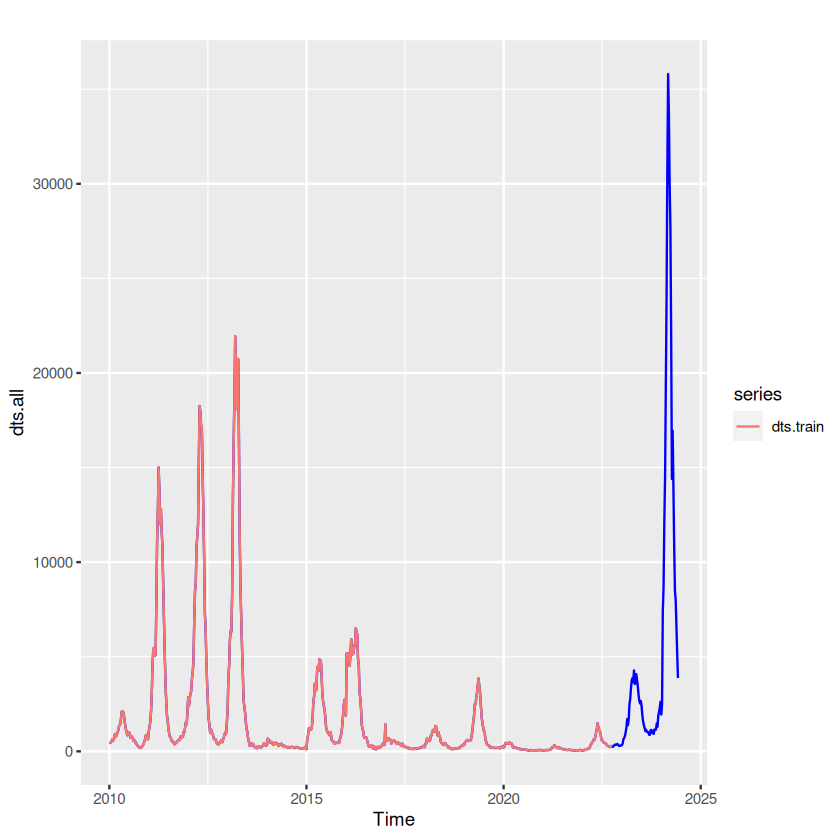

In [68]:
dts.all <- ts(dtRJ$casos, start = c(2010, 01), end = c(2024,23), frequency = 52)
dts.train <- ts(dtRJ$casos[1:which(dtRJ$SE == 202240)], start = c(2010, 01), end = c(2022,40), frequency = 52)

autoplot(dts.all, colour="blue")+
autolayer(dts.train)

In [9]:
?ts

ts {stats},R Documentation
data,a vector or matrix of the observed time-series values. A data frame will be coerced to a numeric matrix via data.matrix. (See also ‘Details’.)
start,"the time of the first observation. Either a single number or a vector of two numbers (the second of which is an integer), which specify a natural time unit and a (1-based) number of samples into the time unit. See the examples for the use of the second form."
end,"the time of the last observation, specified in the same way as start."
frequency,the number of observations per unit of time.
deltat,"the fraction of the sampling period between successive observations; e.g., 1/12 for monthly data. Only one of frequency or deltat should be provided."
ts.eps,time series comparison tolerance. Frequencies are considered equal if their absolute difference is less than ts.eps.
class,"class to be given to the result, or none if NULL or ""none"". The default is ""ts"" for a single series, or c(""mts"", ""ts"", ""matrix"", ""array"") for multiple series."
names,"a character vector of names for the series in a multiple series: defaults to the colnames of data, or ""Series 1"", ""Series 2"", ...."
x,an arbitrary R object.
...,arguments passed to methods (unused for the default method).


In [38]:
fit.train = auto.arima(dts.train, approximation = FALSE)
summary(fit.train)

Series: dts.train 
ARIMA(3,1,5) 

Coefficients:
         ar1    ar2      ar3      ma1      ma2     ma3     ma4      ma5
      0.9073  0.797  -0.7621  -0.3964  -1.1689  0.4825  0.3080  -0.2131
s.e.  0.0568  0.084   0.0515   0.0664   0.0702  0.0667  0.0453   0.0454

sigma^2 = 261113:  log likelihood = -5072.66
AIC=10163.31   AICc=10163.59   BIC=10203.78

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE
Training set -8.778154 507.5176 236.7172 -18.17572 28.83012 0.1442657
                    ACF1
Training set 0.003823684

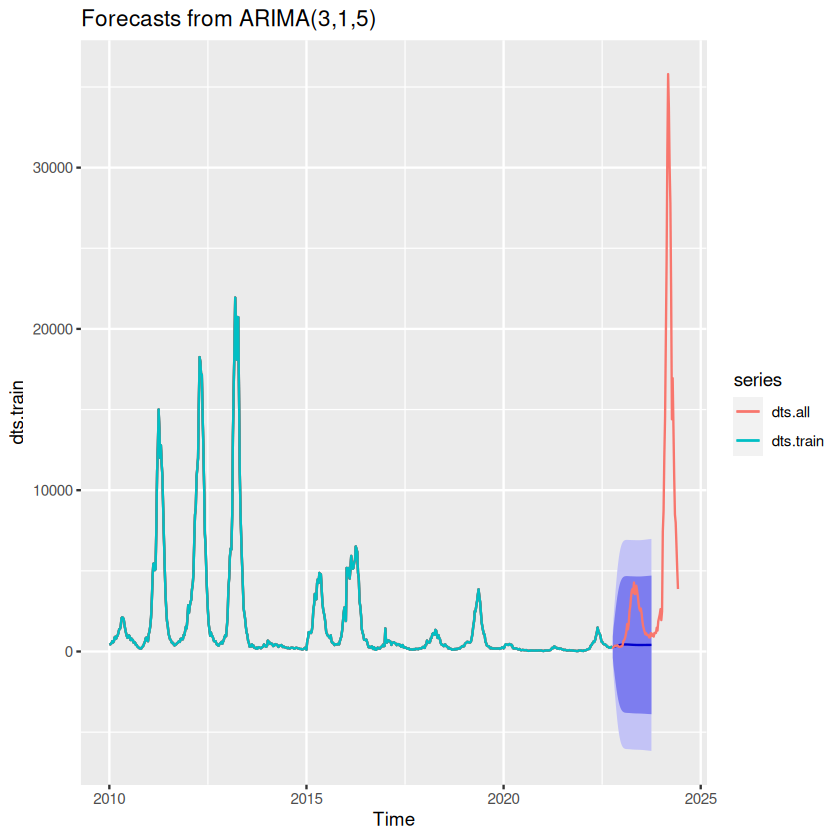

In [70]:
autoplot(forecast(fit.train,h=52))+
autolayer(dts.all)+
autolayer(dts.train)



In [71]:
forecast(fit.train,h=52)

         Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
2022.769       268.8971  -385.9662  923.7603  -732.6298 1270.424
2022.788       282.8255  -903.7232 1469.3743 -1531.8442 2097.495
2022.808       303.6440 -1280.4590 1887.7470 -2119.0324 2726.320
2022.827       312.6948 -1667.1548 2292.5444 -2715.2239 3340.613
2022.846       333.7264 -2038.8719 2706.3247 -3294.8495 3962.302
2022.865       344.1574 -2381.1438 3069.4587 -3823.8312 4512.146
2022.885       363.4872 -2682.9985 3409.9729 -4295.7106 5022.685
2022.904       373.3118 -2945.1096 3691.7332 -4701.7757 5448.399
2022.923       389.6831 -3161.6341 3941.0003 -5041.5878 5820.954
2022.942       397.6369 -3340.3606 4135.6344 -5319.1369 6114.411
2022.962       410.4149 -3478.2182 4299.0479 -5536.7361 6357.566
2022.981       415.8719 -3586.2217 4417.9655 -5704.8021 6536.546
2023.000       424.9462 -3662.6527 4512.5450 -5826.4969 6676.389
2023.019       427.7910 -3719.2802 4574.8623 -5914.6071 6770.189
2023.038       433.4461 -